# Feature Analysis

In [1]:
import pandas as pd

In [2]:
filename1 = 'pionminus'
filename2 = 'electron'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

In [3]:
data1 = pd.read_csv(filepath+f'{filename1}.csv')
data1.loc[data1['phi0'] > -99, 'phi0'] = 0
data2 = pd.read_csv(filepath+f'{filename2}.csv')
data2.loc[data2['phi0'] > -99, 'phi0'] = 1

In [4]:
data = pd.concat([data1,data2], sort=False)
data = data.sample(frac = 1)
data['phi0'] = data['phi0'].astype('int32')
data['centrality'] = data['centrality'].astype('int32')
data['zvertex'] = data['zvertex'].astype('float16')
data['pt'] = data['pt'].astype('float16')
data['e/p'] = data['e/p'].astype('float16')
data['n0'] = data['n0'].astype('int32')
data['disp'] = data['disp'].astype('float16')
data['chi2'] = data['chi2'].astype('float16')
data['npe0'] = data['npe0'].astype('int32')
data['prob'] = data['prob'].astype('float16')
data.head()

,centrality,zvertex,pt,e/p,n0,disp,chi2,npe0,prob,phi0
283936,65,1.174805,0.777344,0.852539,5,2.683594,16.140625,20,0.906250,1
901440,51,-4.050781,1.120117,0.904785,3,3.376953,5.664062,3,0.258789,1
1671574,41,5.003906,1.708008,0.989258,4,1.291016,38.531250,7,0.970703,1
1254914,15,5.878906,0.421387,0.730469,3,1.402344,43.437500,8,0.063293,1
1497101,64,-3.480469,0.526367,0.990723,4,0.748047,72.437500,11,0.842773,1


In [5]:
print(data.size, data.shape, data1.shape, data2.shape)

20743310 (2074331, 10) (348012, 10) (1726319, 10)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)



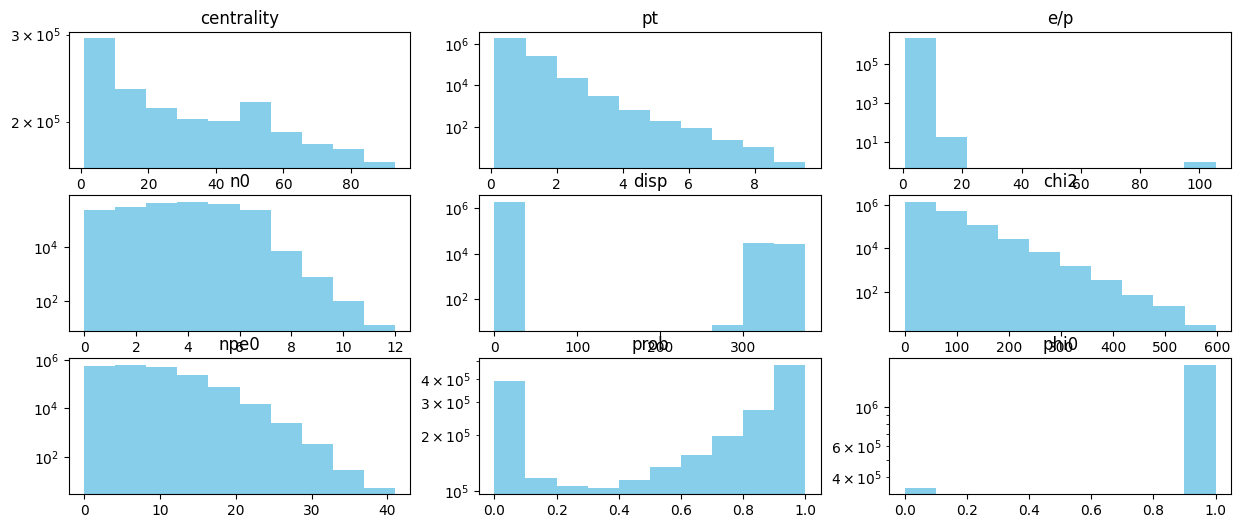

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
from sklearn.preprocessing import OneHotEncoder

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем impressions
    data = data.drop('impressions', axis = 1)
    
    # создаем фичи от времени
    data.date_time = pd.to_datetime(data.date_time)
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    
    # строим графики зависимости количества кликов от дня недели и часа
    data[data['clicks'] > 0].sort_values(by = ['day']).groupby(['day'])['clicks'].sum().plot.barh(title='Clicks by weekday')
    plt.show()
    data[data['clicks'] > 0].sort_values(by = ['hour']).groupby(['hour'])['clicks'].sum().plot.barh(title='Clicks by hour')

    # добавляем интерсекции между часом и днем недели 
    data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
    data['hour_day'] = pd.factorize(data['hour_day'])[0]
    
    # выделяем редкие zone id в категорию -1
    zone_id_counts = data['zone_id'].value_counts()
    idxs = zone_id_counts[zone_id_counts < 10].index
    
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1
    
    # выделяем редкие os_id в категорию 7
    data.loc[data['os_id'] > 7, 'os_id'] = 7
    
    # преобразовываем campaign clicks в бинарную фичу
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')
    
    # делим выборку на train и test
    data = data.sort_values(by='date_time', ignore_index=True)
    cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    y = data['clicks']
    data = data.drop(columns = ['banner_id', 'clicks', 'campaign_clicks', 'date_time'])
    data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    enc.fit(data_train)
    transformed_train = enc.transform(data_train)
    transformed_test = enc.transform(data_test)
    
    return transformed_train, transformed_test, y_train, y_test,cut_off_val

In [10]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [11]:
transformed_train_all, transformed_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

691443 1382888


In [12]:
transformed_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob
1190822,13,0.408203,1.020508,6,0.995605,56.625000,15,0.803711
761724,20,0.647949,1.009766,2,4.863281,43.937500,2,0.406250
1293237,54,0.415771,1.022461,2,7.105469,53.312500,4,0.172852
267330,3,0.556152,0.903320,1,7.792969,2.388672,1,0.027283
1031834,17,0.380615,0.831055,3,3.113281,11.054688,5,0.092590
...,...,...,...,...,...,...,...,...
282100,31,0.373291,1.009766,4,1.661133,61.375000,8,0.869629
1487494,53,0.230957,1.084961,2,6.050781,9.554688,4,0.252441
663003,40,0.455566,0.791016,4,4.296875,34.750000,4,0.357422
58908,10,0.405029,0.807617,1,8.804688,29.156250,1,0.643066


In [13]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, f1_score

In [15]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

# Cross Validation

In [16]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.001,0.01,0.02,0.04,0.08,0.12,1,100]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            print("localy best C:", best_C)       
    print("the best C:", best_C)        
    best_model = create_model(best_C)
    return best_model

In [17]:
print(transformed_val.shape,y_val.shape)

(691445, 8) (691445,)


In [18]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 3.7621804284124374 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.3143604447014592 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.3890764133711289 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.06805291958738194 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.002650292681869082 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 3.8655114257683045e-06 <= 0.0001
    2. Newton decrement 1.1021333731491673e-07 <= 0.0001
  Solver did converge at loss = 0.23939015105557637.
localy best C: 0.001
Newton iter=1
  Check Convergence
    1. max |gradient| 3.777686155657253 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.334518533579031 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.4038007739253518 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.07461637048787845 <= 0.0001
Newton iter=5

Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [19]:
clf.fit(transformed_train_all, y_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 3.769395922195026 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 1.3309721311163825 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.4023709561419331 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.07433237661780671 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.0033356155016953364 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 6.5772027568416955e-06 <= 0.0001
    2. Newton decrement 1.9500238786325867e-07 <= 0.0001
  Solver did converge at loss = 0.23602971815400237.


LogisticRegression(C=0.04, max_iter=10000, solver='newton-cholesky', verbose=1)

# Model Evaluation

In [20]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [21]:
clf

LogisticRegression(C=0.04, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.23690138282044954
roc auc: 0.9269737999878411
f1 score: 0.9087242379419623


Text(0.5, 1.0, 'ROC AUC Curve')

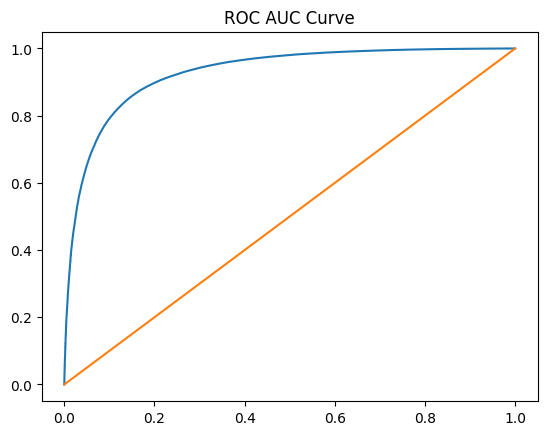

In [22]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [23]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.45216255005080896


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.

In [24]:
i = 7000
print(thresholds[i],fpr[i],tpr[i])
print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.9733539579289936 0.030621927024928837 0.5443943056021323
881.8767394049171 1619.9227845146345


In [25]:
print(clf.intercept_)
for keff in clf.coef_[0]:
    print(keff)
output_data = [clf.intercept_,clf.coef_[0]]
with open("output/keffs.txt", "w") as txt_file:
    for line in output_data:
        txt_file.write("".join(str(line)) + "\n")

[-4.95196417]
0.022867510664669705
0.7367812371829467
0.8259045045584832
0.6683955810537316
-0.0008989044312970276
0.0018355961602193448
0.2515775091393416
2.4067023041254267


In [26]:
def answer(centrality,pt,ep,n0,disp,chi2,npe0,prob):
    ans = clf.coef_[0][0]*centrality+clf.coef_[0][1]*pt+clf.coef_[0][2]*ep+clf.coef_[0][3]*n0+\
        clf.coef_[0][4]*disp+clf.coef_[0][5]*chi2+clf.coef_[0][6]*npe0+clf.coef_[0][7]*prob+clf.intercept_[0]
    return ans

In [27]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.9997736246255925


In [28]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 and centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>0.9727650435469417: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    if counter<10: 
        print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

[2.26375374e-04 9.99773625e-01] 8.393089586835082
[0.2356037 0.7643963] 1.1769352097574206
[0.00738091 0.99261909] 4.9014500062388855
[0.36507033 0.63492967] 0.5534242049851708
[0.00487305 0.99512695] 5.3191495531926964
[0.03073537 0.96926463] 3.4511234077292503
[0.01176566 0.98823434] 4.430735024041715
[0.17130583 0.82869417] 1.576400761823697
[0.74348584 0.25651416] -1.0641658640200835
[0.82616343 0.17383657] -1.5586769725580676


In [29]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

83395 16606 0.507 0.013 0.55 0.03 0.055 0.056
